<a href="https://colab.research.google.com/github/juanfranbrv/curso-langchain/blob/main/99.%20Cargadores%20de%20datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Preparando el entorno del cuaderno**
---
Configuramos el entorno de trabajo para utilizar LangChain con distintos modelos de lenguaje (LLMs).

- Obtenemos las claves API para acceder a los servicios de OpenAI, Groq, Google y Hugging Face.

- Instalamos la librería LangChain y las integraciones necesarias para cada uno de estos proveedores.

- Importamos las clases específicas de LangChain que permiten crear plantillas de prompts e interactuar con los diferentes modelos de lenguaje, dejándolo todo listo para empezar a desarrollar aplicaciones basadas en LLMs. (Este codigo se explico con detalle en el primer cuaderno)

Comenta (#) las librerias y modelos que no desees usar.

In [2]:
%%capture --no-stderr

# Importar la librería `userdata` de Google Colab.
# Esta librería se utiliza para acceder a datos de usuario almacenados de forma segura en el entorno de Colab.
from google.colab import userdata

# Obtener las claves API de diferentes servicios desde el almacenamiento seguro de Colab.
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
GROQ_API_KEY=userdata.get('GROQ_API_KEY')
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
HUGGINGFACEHUB_API_TOKEN=userdata.get('HUGGINGFACEHUB_API_TOKEN')

# Instalar las librerías necesarias usando pip.
# El flag `-qU` instala en modo silencioso (`-q`) y actualiza las librerías si ya están instaladas (`-U`).
%pip install langchain -qU  # Instalar la librería principal de LangChain.
%pip install langchain-community  -qU # Instalar el paquete langchain-community, necesario para los Loaders

# Instalar las integraciones de LangChain con diferentes proveedores de LLMs.
%pip install langchain-openai -qU
%pip install langchain-groq -qU
%pip install langchain-google-genai -qU
%pip install langchain-huggingface -qU

%pip install rich -qU

# Importar las clases necesarias de LangChain para crear plantillas de prompt.
# `ChatPromptTemplate` es la clase base para plantillas de chat.
# `SystemMessagePromptTemplate` se usa para mensajes del sistema (instrucciones iniciales).
# `HumanMessagePromptTemplate` se usa para mensajes del usuario.
from langchain.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Importar las clases para interactuar con los diferentes LLMs a través de LangChain.
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEndpoint

# Importamos la libreria para formatear mejor la salida
from IPython.display import Markdown, display
from rich import print as rprint

# **1. Poner los ficheros en el entorno del cuaderno**
---

Para los siguientes ejemplos vamos a cargar varios ficheros desde el repositorio de los cuadernos

https://github.com/juanfranbrv/curso-langchain

Si deseas usar tu propios ficheros, solo tienes que subirlos al entorno del cuaderno aunque desapareceran al reiniciar el entorno.

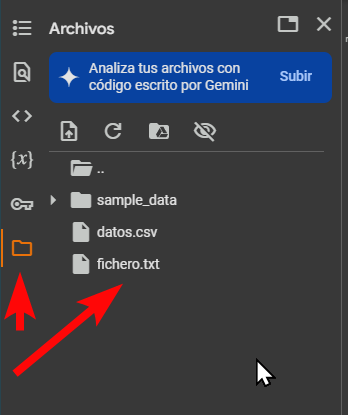

In [6]:
!wget https://raw.githubusercontent.com/juanfranbrv/curso-langchain/main/datasets/datos.csv -O datos.csv
!wget https://raw.githubusercontent.com/juanfranbrv/curso-langchain/main/datasets/fichero.txt -O fichero.txt

--2025-03-24 09:19:41--  https://raw.githubusercontent.com/juanfranbrv/curso-langchain/main/datasets/datos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1493 (1.5K) [text/plain]
Saving to: ‘datos.csv’

datos.csv           100%[===================>]   1.46K  --.-KB/s    in 0s      

2025-03-24 09:19:41 (17.4 MB/s) - ‘datos.csv’ saved [1493/1493]

--2025-03-24 09:19:41--  https://raw.githubusercontent.com/juanfranbrv/curso-langchain/main/datasets/fichero.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7487 (7.3K) [text/pla

# **1. Documents Loaders en LangChain: La Puerta de Entrada a la Información**
---

Los modelos de lenguaje son poderosos, pero necesitan datos para trabajar. Aquí es donde entran en juego los Data Loaders. Piensa en ellos como los "cargadores" que toman información de diferentes lugares (documentos PDF, páginas web, bases de datos, etc.) y la preparan para que el modelo de lenguaje pueda entenderla y utilizarla.

## **¿Para qué sirven y por qué son importantes?**

- **Extracción:** Los Documents Loaders extraen la información relevante de diversas fuentes, sin importar su formato original.
    
- **Preparación:** Transforman esa información en un formato que los modelos de lenguaje pueden procesar (generalmente, texto plano).
    
- **Eficiencia:** Hacen todo esto de manera eficiente, lo que te permite alimentar a tus modelos con grandes cantidades de datos sin complicaciones.
    
- **Simplifican el acceso a los datos:** Ya no tienes que preocuparte por escribir código complejo para extraer información de cada tipo de archivo.
    
- **Permiten la escalabilidad:** Puedes procesar grandes volúmenes de datos para entrenar o interactuar con modelos de lenguaje más potentes.
    
- **Son el primer paso de un proceso:** Los datos limpios y bien estructurados son el comienzo de cualquier proyecto con LLM.
    

En este Colab, exploraremos cómo usar los Documents Loaders de LangChain para cargar y preparar datos de diferentes fuentes, ¡y así dar rienda suelta al poder de los modelos de lenguaje!



# **2. Tipos de Documents Loaders en LangChain**
---

LangChain ofrece una variedad de loaders para trabajar con diferentes tipos de fuentes de datos (archivos locales, páginas web, servicios en la nube, etc.). Cada uno tiene sus particularidades y ventajas, permitiéndote elegir el mejor para tu proyecto y asegurando que solo la información más relevante alimente tus flujos de trabajo.

Algunos importantes son los siguientes:

-   **Cargadores para archivos locales**
    -   _TextLoader_: para archivos .txt.
    -   _CSVLoader_: para archivos .csv.
    -   _PDFLoader_: para documentos en PDF (con dependencias como `PyPDF2` o `pdfminer`).
    -   _UnstructuredFileLoader_: para distintos tipos de archivos basados en librerías “unstructured”.
-   **Cargadores para fuentes web**
    -   _WebBaseLoader_: para extraer texto desde páginas web.
    -   _URLsLoader_: para múltiples URLs de forma simultánea.
    -   Consideraciones sobre rate-limiting, HTML parsing, etc.
-   **Cargadores para APIs o servicios en la nube**
    -   _GoogleDriveLoader_: lectura de documentos en Google Drive.
    -   _S3Loader_ (Amazon): acceso a buckets S3.
    -   _OneDriveLoader_: conexión con Microsoft OneDrive.
    -   Factores de autenticación y permisos.
-   **Cargadores especializados**
    -   _YouTubeLoader_: extracción de transcripciones de videos de YouTube.
    -   _EverNoteLoader_, _NotionLoader_, etc., dependiendo de integraciones específicas.
    -   Cargadores basados en servicios de bases de datos (por ejemplo, MySQL, PostgreSQL).

Aquí puedes encontrar todos: https://python.langchain.com/docs/integrations/document_loaders/

#**3. Flujo de trabajo básico con Document Loaders**
---
La idea principal es elegir el loader adecuado para tu fuente de datos (archivos, web, API), configurarlo con las librerías necesarias y ejecutar la extracción de información. Tras obtener el contenido, se pueden aplicar pasos como chunking, limpieza de texto y enriquecimiento de metadatos, antes de utilizarlo en cadenas o modelos dentro de LangChain.

Vamos a ver algunos ejemplos.

# **TextLoader**
---
TextLoader es un documento loader (cargador de documentos) de LangChain que permite cargar archivos de texto plano en documentos que pueden ser procesados posteriormente. Sus características principales son:

- Carga archivos de texto directamente desde el sistema de archivos  

- Convierte el contenido del archivo en un objeto Document de LangChain

- Permite especificar la codificación del archivo (por defecto usa UTF-8)

`documentos = loader.load() `

Aquí es donde ocurre la magia. El método load() hace lo siguiente:

- Lee el contenido del archivo de texto.
    
- Crea un objeto Document de LangChain. Un Document es una estructura de datos simple que contiene:
    
    - page\_content: El texto del documento (en este caso, el contenido del archivo).
        
    - metadata: Un diccionario con metadatos sobre el documento (opcional). Por defecto, TextLoader incluye el nombre del archivo en los metadatos (source).
        
    
- Devuelve una lista de objetos Document. Aunque en este caso solo cargamos un archivo, load() siempre devuelve una lista, porque algunos cargadores pueden dividir un solo archivo en múltiples documentos (por ejemplo, un PDF se puede dividir por páginas).


## **🧪 Ejemplo: Resumen de un texto**

In [8]:
from langchain.document_loaders import TextLoader

# Cargamos el contenido de un archivo de texto
ruta_fichero = "/content/fichero.txt"  # Ajusta la ruta según tu caso
loader = TextLoader(ruta_fichero)
documentos = loader.load()

print(f"Se han cargado {len(documentos)} documento(s).")
# if documentos:
#     print("Primer documento - Metadatos:", documentos[0].metadata)
#     print("Primer documento - Contenido (primeros 200 caracteres):")
#     print(documentos[0].page_content[:200], "...")

# Tomamos el texto cargado como 'contexto_texto'
contexto_texto = documentos[0].page_content if documentos else "Sin contenido"

# Definimos un prompt para resumir el contenido
texto_prompt = """
El siguiente texto proviene de un archivo local:

"{texto}"

Por favor, elabora un resumen breve (no más de 3 líneas) que capture
las ideas principales del contenido anterior.
"""

prompt_template = PromptTemplate(
    template=texto_prompt,
    input_variables=["texto"]
)

# Generamos el prompt usando el texto cargado
prompt = prompt_template.format(texto=contexto_texto)


# Instanciamos el modelo (comenta el que no desees usar)
modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)
modelo = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY,temperature=0)

# Hacemos la llamada al LLM para obtener el resumen
respuesta = modelo.invoke(prompt).content

rprint(respuesta)

Se han cargado 1 documento(s).


Python es un lenguaje de programación de alto nivel y multiparadigma creado por Guido van Rossum en la década de 1980. Ha evolucionado a lo largo de los años, con versiones como Python 2.0 y Python 3.5, y se utiliza en campos como la inteligencia artificial y el machine learning. Su filosofía se centra en la legibilidad y la facilidad de uso.

Python es un lenguaje de programación de alto nivel y multiparadigma creado por Guido van Rossum en la década de 
1980. Ha evolucionado a lo largo de los años, con versiones como Python 2.0 y Python 3.5, y se utiliza en campos 
como la inteligencia artificial y el machine learning. Su filosofía se centra en la legibilidad y la facilidad de 
uso.

## **🧪 Ejemplo: Análisis de un log**

Tenemos un fichero de registro de un servidor y queremos realizar un analisis preliminar

In [14]:
!wget https://raw.githubusercontent.com/juanfranbrv/curso-langchain/refs/heads/main/datasets/mail.log -O mail.log


from langchain.document_loaders import TextLoader

# Cargamos el contenido de un archivo de texto
ruta_fichero = "/content/mail.log"  # Ajusta la ruta según tu caso
loader = TextLoader(ruta_fichero)
documentos = loader.load()

print(f"Se han cargado {len(documentos)} documento(s).")
# if documentos:
#     print("Primer documento - Metadatos:", documentos[0].metadata)
#     print("Primer documento - Contenido (primeros 200 caracteres):")
#     print(documentos[0].page_content[:200], "...")

# Tomamos el texto cargado como 'contexto_texto'
contexto_texto = documentos[0].page_content if documentos else "Sin contenido"

# Definimos un prompt para resumir el contenido
texto_prompt = """
El siguiente texto proviene del registro del servidor de corre:

"{texto}"

Realiza un resumen y analisis preliminar del contenido anterior.
"""

prompt_template = PromptTemplate(
    template=texto_prompt,
    input_variables=["texto"]
)

# Generamos el prompt usando el texto cargado
prompt = prompt_template.format(texto=contexto_texto)


# Instanciamos el modelo (comenta el que no desees usar)
modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)
# modelo = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY,temperature=0)

# Hacemos la llamada al LLM para obtener el resumen
respuesta = modelo.invoke(prompt).content

rprint(respuesta)

--2025-03-24 10:23:09--  https://raw.githubusercontent.com/juanfranbrv/curso-langchain/refs/heads/main/datasets/mail.log
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60674 (59K) [text/plain]
Saving to: ‘mail.log’

mail.log            100%[===================>]  59.25K  --.-KB/s    in 0.01s   

2025-03-24 10:23:09 (4.21 MB/s) - ‘mail.log’ saved [60674/60674]

Se han cargado 1 documento(s).


El texto proporcionado es un registro de actividad del servidor de correo, específicamente de la biblioteca 
PHPMailer utilizada en un sitio web de WordPress. A continuación, se presenta un resumen y análisis preliminar del 
contenido:

### Resumen del Contenido

1. **Fechas y Tiempos**: Los registros abarcan desde el 14 de febrero de 2025 hasta el 20 de febrero de 2025, con 
múltiples entradas por día.

2. **Destinatarios**: La mayoría de los correos se envían a la dirección `taller@trtautomoviles.es` y 
`info@elserralet.com`, así como a `juanfranbrv@gmail.com`, que parece ser un destinatario recurrente.

3. **Asuntos de los Correos**: Los asuntos de los correos son variados, incluyendo:
   - Mensajes desde formularios de contacto en la web.
   - Alertas de seguridad de Wordfence y Sucuri.
   - Notificaciones de pedidos realizados en tiendas en línea.
   - Mensajes de spam o publicidad, como "loli porn" y otros temas no deseados.

4. **Remitentes**: Los correos son enviados principalmente desde direcciones de WordPress asociadas a los dominios 
mencionados, pero también incluyen direcciones de correo de remitentes externos, lo que sugiere que algunos correos
pueden ser generados por formularios de contacto.

5. **Contenido de los Correos**: Aunque el contenido específico de los correos no se muestra en el registro, se 
puede inferir que muchos de ellos son respuestas automáticas a formularios de contacto, así como alertas de 
seguridad.

### Análisis Preliminar

1. **Frecuencia de Correos**: Hay una alta frecuencia de correos enviados, lo que podría indicar un uso activo del 
sitio web, pero también podría ser un signo de actividad sospechosa, especialmente si muchos de los correos son 
spam.

2. **Problemas de Seguridad**: La presencia de múltiples alertas de Sucuri y Wordfence sugiere que el sitio web 
podría estar enfrentando problemas de seguridad, como intentos de acceso no autorizados o vulnerabilidades.

3. **Spam y Publicidad**: La inclusión de correos con contenido de spam indica que el sitio web podría estar 
expuesto a ataques de spam, lo que podría afectar la reputación del dominio y la experiencia del usuario.

4. **Necesidad de Filtrado**: Dada la cantidad de correos no deseados, sería recomendable implementar medidas de 
filtrado más estrictas en los formularios de contacto y en el servidor de correo para reducir el spam.

5. **Revisión de Seguridad**: Se sugiere realizar una revisión exhaustiva de la seguridad del sitio web, incluyendo
la actualización de plugins, la implementación de medidas de seguridad adicionales y la revisión de los registros 
de acceso para identificar posibles brechas.

### Conclusión

El registro del servidor de correo revela una actividad intensa y variada, con un enfoque en la comunicación a 
través de formularios de contacto y alertas de seguridad. Sin embargo, también destaca la necesidad de abordar 
problemas de seguridad y spam para proteger la integridad del sitio web y mejorar la experiencia del usuario.

## CsvLoader

asa

In [ ]:
from langchain.document_loaders import CSVLoader
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from IPython.display import Markdown, display
import os


# Cargamos el contenido de un archivo CSV
ruta_fichero = "/datos.csv"  # Ajusta la ruta según tu caso
loader = CSVLoader(ruta_fichero)
documentos = loader.load()

print(f"Se han cargado {len(documentos)} documento(s).")

# Tomamos el primer documento para ejemplificar un análisis
contexto_texto = documentos[0].page_content if documentos else "Sin contenido"

# Prompt para realizar un análisis específico de los datos
texto_prompt = """
El texto a continuación representa los datos de un registro en un archivo CSV:

"{texto}"

Por favor, analiza este registro e indica:
1. Un posible uso que se podría dar a esta información.
2. Una hipótesis acerca del comportamiento o tendencia reflejada en estos datos.
3. Una recomendación para mejorar o dar mayor contexto a este registro de datos.
"""

prompt_template = PromptTemplate(
    template=texto_prompt,
    input_variables=["texto"]
)

# Generamos el prompt usando el texto cargado
prompt = prompt_template.format(texto=contexto_texto)

# Instanciamos el modelo
llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0.7)

# Hacemos la llamada al LLM para obtener el análisis
respuesta = llm.invoke(prompt)

display(Markdown(respuesta.content))


Se han cargado 2729 documento(s).


<ipython-input-17-29e99b5d8a99>:39: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0.7)


Claro, aquí tienes un análisis del registro proporcionado:

### 1. Posible uso de la información:
Esta información podría ser utilizada por entidades gubernamentales, organizaciones culturales o instituciones educativas para la gestión del patrimonio cultural. Por ejemplo, el registro detalla un inmueble afectado culturalmente, lo que podría servir para la planificación de intervenciones, conservación, o promoción de actividades culturales en el mismo. Además, podría ser útil para investigadores que estudian la disponibilidad de espacios culturales en la provincia de Valencia.

### 2. Hipótesis sobre el comportamiento o tendencia reflejada en estos datos:
Una posible hipótesis es que las propiedades catalogadas como "Cultural" y "Suelo Urbano" podrían estar aumentando en número en la provincia de Valencia debido a un creciente interés por la recuperación y conservación del patrimonio cultural. Esto podría reflejar una tendencia hacia la valorización de espacios que tienen un significado histórico o cultural, impulsada por políticas públicas que fomentan la educación y la preservación del patrimonio.

### 3. Recomendación para mejorar o dar mayor contexto a este registro de datos:
Para dar mayor contexto y utilidad a este registro, se podría incluir información adicional como:

- **Coordenadas Geográficas**: Incluir latitud y longitud para facilitar la ubicación del inmueble en un mapa.
- **Descripción Detallada**: Proporcionar una breve descripción del inmueble, su historia, importancia cultural y cualquier evento relevante que haya tenido lugar allí.
- **Estado de Conservación**: Incluir detalles sobre el estado actual del inmueble y cualquier intervención de conservación realizada o planificada.
- **Datos de Contacto**: Añadir información de contacto de la entidad responsable de la gestión del inmueble para facilitar la consulta de interesados o investigadores.

Esto enriquecería el registro, haciéndolo más accesible y útil para diversos usuarios.

# Referencias
---

1. https://python.langchain.com/docs/integrations/document_loaders/

2. https://blog.davideai.dev/the-ultimate-langchain-series-data-loaders

3. https://www.youtube.com/watch?v=zKlZ8Atv6Bc

4. https://www.youtube.com/watch?v=75uBcITe0gU

# Guión

## 1\. Introducción a los Document Loaders

1.  **Definición de Document Loaders**
    -   ¿Qué son los Document Loaders?
    -   Relación con el proceso general de generación y/o procesamiento de lenguaje en LangChain.
2.  **Por qué son importantes**
    -   Papel fundamental en la preparación de datos: localización, extracción y preprocesamiento.
    -   Garantizar que los datos se adapten al modelo y al flujo de trabajo (por ejemplo, chunking).
    -   Reducción de costos y optimización de rendimiento cuando se limitan los datos innecesarios.

* * *

## 2\. Tipos de Document Loaders en LangChain

1.  **Cargadores para archivos locales**
    -   _TextLoader_: para archivos .txt.
    -   _CSVLoader_: para archivos .csv.
    -   _PDFLoader_: para documentos en PDF (con dependencias como `PyPDF2` o `pdfminer`).
    -   _UnstructuredFileLoader_: para distintos tipos de archivos basados en librerías “unstructured”.
2.  **Cargadores para fuentes web**
    -   _WebBaseLoader_: para extraer texto desde páginas web.
    -   _URLsLoader_: para múltiples URLs de forma simultánea.
    -   Consideraciones sobre rate-limiting, HTML parsing, etc.
3.  **Cargadores para APIs o servicios en la nube**
    -   _GoogleDriveLoader_: lectura de documentos en Google Drive.
    -   _S3Loader_ (Amazon): acceso a buckets S3.
    -   _OneDriveLoader_: conexión con Microsoft OneDrive.
    -   Factores de autenticación y permisos.
4.  **Cargadores especializados**
    -   _YouTubeLoader_: extracción de transcripciones de videos de YouTube.
    -   _EverNoteLoader_, _NotionLoader_, etc., dependiendo de integraciones específicas.
    -   Cargadores basados en servicios de bases de datos (por ejemplo, MySQL, PostgreSQL).

* * *

## 3\. Flujo de trabajo básico con Document Loaders

1.  **Selección del Loader adecuado**
    -   Identificar el tipo de fuente de datos (archivo, web, API, etc.).
    -   Compatibilidad y requerimientos (dependencias, librerías adicionales).
    -   Métodos de autenticación o acceso a la fuente de datos.
2.  **Configuración e inicialización**
    -   Instalación de librerías necesarias (por ejemplo, `requests`, `beautifulsoup4`, `PyPDF2`, `google-api-python-client`, etc.).
    -   Parámetros de configuración (paths, URL, tokens de acceso).
3.  **Extracción de documentos**
    -   Ejecución del loader para obtener el contenido bruto.
    -   Lectura incremental, por lotes o tiempo real (según el caso).
    -   Manejo de excepciones y errores de conexión o acceso.
4.  **Ejemplo práctico**
    -   Demostración de un caso simple (por ejemplo, cargar un PDF).
    -   Revisión del objeto resultante y metadatos (título, fuente, etc.).
    -   Cómo se integran esos datos en una _chain_ posterior.

* * *

## 4\. Preprocesamiento y Normalización

1.  **Chunking (segmentación de texto)**
    -   Por qué es necesario (limitación de tokens, segmentación semántica, etc.).
    -   Estrategias de chunking: por número de tokens, por longitud de caracteres, por secciones lógicas.
    -   Ejemplo de implementación de chunking en LangChain.
2.  **Limpieza y formateo de texto**
    -   Remoción de caracteres especiales, saltos de línea, metadatos irrelevantes.
    -   Conversión a minúsculas o mantenimiento del caso original.
    -   Manejo de signos de puntuación y otras normalizaciones.
3.  **Enriquecimiento de metadatos**
    -   Agregar fecha, autor, tipo de documento, fuente, URL, etc.
    -   Efecto en la relevancia y filtrado posterior con los LLMs.
    -   Uso de metadatos para afinar búsquedas en bases vectoriales.

